# Mood-RL Model Fitting
## Section 1: Motivating model parameterization  
### Explaining the "Matt trick"
To fit reinforcement learning models with Stan, we utilize non-centered parameterizations (aka the "Matt trick"). This parameterization improves the efficiency of MCMC sampling by making the sampling space uniformly dense. Traditionally in Bayesian modeling, the inverse temperature ($\beta$) and learning rate ($\eta$) are sampled from directly (often with non-informative uniform priors). We will instead employ a two-step procedure where we will first sample from independent unit normal priors and then transform the samples into their appropriate parameter spaces:

> $\beta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta = C \cdot \text{Phi_approx}(\beta_{pr})$

> $\eta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta = \text{Phi_approx}(\eta_{pr}) $

where *Phi_approx* is a fast approximation of the cumulative unit normal [(Bowling et al., 2009)](http://www.jiem.org/index.php/jiem/article/view/60):

> $\text{Phi_approx}(x) = \text{logit}^{-1}(0.07056 \ x^3 + 1.5976 \ x) $

As an approximation of the cumulative unit normal, the *Phi_approx* function conveniently scales its inputs to be in the range $x \in (0, 1)$. As such, samples from $\eta_{pr}$ are of appropriate scale following transformation. Because values of $\beta$ are normally much larger than 1, a scaling function, $C$, is used to scale the samples of $\beta_{pr}$ to an appropriate range. For example, a user would set $C=20$ to sample $\beta \in (0,20)$.

For details, see the [Stan users manual](http://mc-stan.org/users/documentation/) (section 28.6). The [*hBayesDM*](https://github.com/CCS-Lab/hBayesDM) and [*fitr*](https://github.com/abrahamnunes/fitr) packages provided the templates for fitting these models.

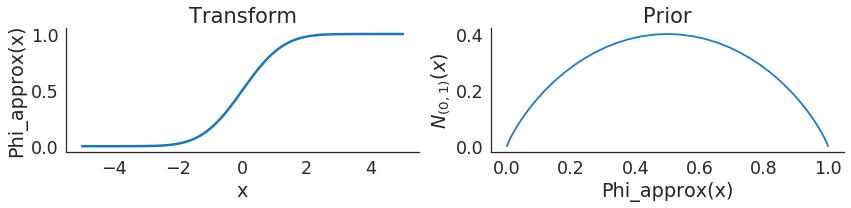

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm
from scripts.utilities import phi_approx
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)

## Plot Phi_approx function.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', ylabel='Phi_approx(x)', title='Transform')

## Plot prior.
axes[1].plot(phi_approx(x), norm(0,1).pdf(x))
axes[1].set(xlabel='Phi_approx(x)', ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

**Figure 1:** Visualizing the *Phi_approx* function. (Left) The transformation of arbitrary values, $x$, through *Phi_approx*. (Right) The probability density of *Phi_approx* scaled values, $x$, sampled from a unit normal distribution.

### Hierarchical parameterization
Non-centered parameterizations are especially useful for hierarchical models, where parameters may vary dramatically in scale (resulting in sampling issues). As such, all subject parameters are similarly sampled from a unit normal prior and transformed. To make the model hierarchical, i.e. to enforce partial pooling, subject-level parameters ($\beta_i, \eta_i$) are estimated using a similar two-step procedure:

> $\beta_{pr, i} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta_i = C \cdot \text{Phi_approx}(\beta_{pr,\mu} + \sigma_{\beta} \cdot \beta_{pr,i})$

> $\eta_{pr,i} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta_i = \text{Phi_approx}(\eta_{pr,\mu} + \sigma_{\eta} \cdot \eta_{pr,i}) $

where $\beta_{pr,\mu}$ and $\eta_{pr,\mu}$ are the group-level inverse temperature and learning rates, respectively; and $\sigma$ captures the variance of the subject-level parameters around the group mean. As above, the group-level parameters are also sampled through a unit normal prior. The variances can be sampled through a half-cauchy distribution or gamma distribution.  

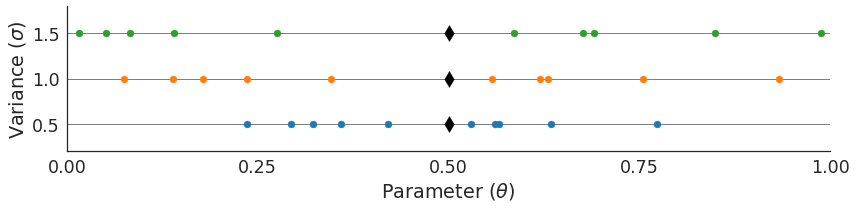

In [2]:
## Randomly generate arbitrary subject-level parameters.
np.random.seed(47404)
theta = np.random.normal(0,1,10)
sigma = [0.5,1,1.5]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
for s in sigma:
    ax.scatter(phi_approx(0 + s * theta), np.ones_like(theta)*s)
ax.scatter(phi_approx(np.zeros(3)), [0.5,1,1.5], s=130, marker='d', color='k')
    
## Add info.
ax.hlines(sigma, 0, 1, lw=0.5, zorder=0)
ax.set(xlim=(0,1), xticks=np.linspace(0,1,5), xlabel=r'Parameter ($\theta$)', 
       ylim=(0.2, 1.8), yticks=sigma, ylabel=r'Variance ($\sigma$)')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Visualizing the hierarchical model. Arbitrarily sampled subject-level variables, $\theta_i$ (color circles), are distributed around a group-level variable, $\theta_\mu$ (diamonds). The variance of their distribution is dictated by $\sigma$. When $\sigma < 1$, the subject-level parameters shrink towards group-level value; when $\sigma > 1$, the subject-level parameters move away from group-level value.

### Prior on the mood-bias parameter ($f$) 

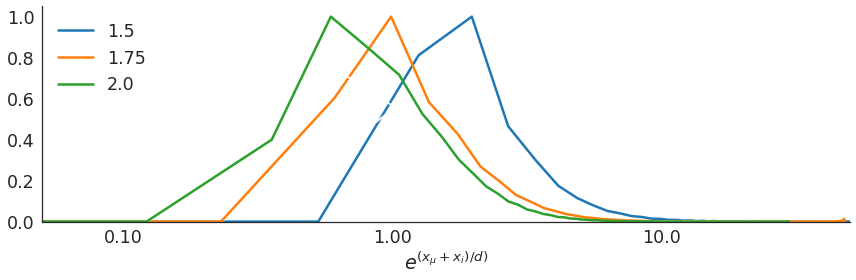

In [3]:
np.random.seed(47404)

## Simulate data.
f_pr = np.random.multivariate_normal(np.zeros(2), np.identity(2), int(1e6))
divisor = [1.5, 1.75, 2.0]

fig, ax = plt.subplots(1,1,figsize=(12,4))
for d in divisor:
    
    ## Compute f (assumings sigma = 1).
    f = np.exp( np.sum(f_pr, axis=1) / d )
    
    ## Plot.
    sns.kdeplot(f, color='w', ax=ax)
    line = ax.lines[-1]
    xdata, ydata = line.get_xdata(), line.get_ydata()
    ax.plot(xdata, ydata/ydata.max(), lw=2.5, label=d)
    
ax.set_xscale('log')
ax.set(xlim=(0.05, 50), xticks=np.logspace(-1,2,4), xlabel=r'$e^{(x_\mu + x_i)/d)}$', 
       ylim=(0,1.05), xticklabels=['0.10','1.00','10.0','100.'])
ax.legend(loc=2)
sns.despine()
plt.tight_layout()

## Section 2: Model fitting
The following block of code is used to fit the Stan models found in the *stan_models* directory. The models are parameterized to receive the same inputs as specified below. 

All models run with the same sampling parameters (2500 samples, 2000 burn-in, 4 chains, no thinning, *adapt_delta* = 0.9).

In [4]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 2500
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
dt = data.Datetime.unique()

## Extract and prepare stimulus presentation data.
X = data[['M1','M2']].values.reshape(N,B,T,2)

## Extract and prepare choice data. 
## Missing values coded as -1.
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )

## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, h12=h12, WoF=WoF)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      control=dict(adapt_delta = 0.9), n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)
        
    print('Done.')

<IPython.core.display.Javascript object>

## Section 3: Model Comparisons
In this next section, we conduct model comparisons for the series of models fitted above. To do so, employ the widely applicable information criterion (WAIC; [Watanabe, 2010](http://www.jmlr.org/papers/volume11/watanabe10a/watanabe10a.pdf); [Gelman et al., 2014](https://link.springer.com/article/10.1007/s11222-013-9416-2); [Vehtari et al., 2017](https://link.springer.com/article/10.1007/s11222-016-9696-4)). The WAIC is a model performance metric that takes into consideration the entire posterior distribution. The WAIC is defined as:

> $\text{elppd}_{\text{waic}} = \text{lppd} - \text{pWAIC} $

where *elppd* is the expected log pointwise predictive density; *lppd* is the log pointwise predictive density; and pWAIC is a bias correction term. Conceptually, the WAIC is similar to the AIC or BIC in that the first term represents the goodness-of-fit of the model and the second term penalizes for model complexity. The WAIC differs, as mentioned above, in that it takes into consideration the full posterior density. For a set of $i \in N$ total observations, $y$, and $s \in S$ total posterior samples, $\theta$, the terms are computed as:

> $\text{lppd} = \sum \text{log} \ ( \frac{1}{S} \sum p(y_i \ | \ \theta^s)) $

> $\text{pWAIC} = \sum \text{Var} \ (\text{log} \ p(y_i \ | \ \theta^s))$

Briefly, it is worth mentioning that some have called for using alternatives performance metrics other than the WAIC (e.g. CV-LOO; [Gelman et al., 2014](https://link.springer.com/article/10.1007/s11222-013-9416-2); [Vehtari et al., 2017](https://link.springer.com/article/10.1007/s11222-016-9696-4)). As has been reported elsewhere (and observed in testing with these data), the WAIC and CV-LOO yield comparable estimates for data with many observations ([Watanabe, 2010](http://www.jmlr.org/papers/volume11/watanabe10a/watanabe10a.pdf); [Gelman et al., 2014](https://link.springer.com/article/10.1007/s11222-013-9416-2)). As such we use the more familiar WAIC metric.

### No-pooling vs. partial-pooling
In this first comparison, we test to see if hierarchically modeling participants' behavior improves model estimates. Previous work has shown that partial-pooling of data can improve model fitting and parameter recovery ([Gelman et al., 2013](http://www.stat.columbia.edu/~gelman/book/); [Kruschke, 2014](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0); [Lee & Wagenmakers, 2014](https://bayesmodels.com/)). Insofar that reinforcement learning models often suffer from identifiability issues ([Daw, 2011](http://www.cns.nyu.edu/~daw/d10.pdf); [Gershman, 2016](http://www.sciencedirect.com/science/article/pii/S0022249616000080)), hierarchical modeling may improve model estimation here.  

The two models compared below are the *no pooling* and *partial-pooling* baseline models. The baseline models represent the canonical Q-learning reinforcement learning models with two parameters (inverse temperature, $\beta$, and learning rate, $\eta_v$). The models differ only in that, in the partial-pooling model, each subject-level parameter ($\beta_i$, $\eta_i$) is assumed to be drawn from a normally distributed group-level parameter ($\beta_\mu$, $\eta_\mu$). 

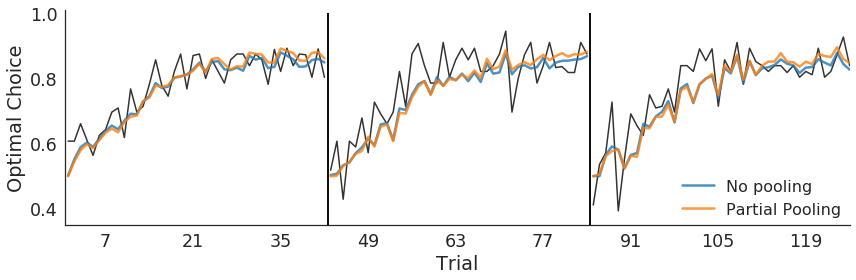

In [5]:
from scripts.plotting import plot_behavior
from scripts.utilities import model_comparison

## Define parameters.
models = ['moodRL_original_no_pool', 'moodRL_original_no_mood']
colors = sns.color_palette(n_colors=len(models))
labels = ['No pooling', 'Partial Pooling']

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [True,False], colors, labels):
    plot_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=16)

sns.despine()
plt.tight_layout()

In [6]:
## Compute model comparison.
model_comparison('moodRL_original_no_pool', 'moodRL_original_no_mood', on='y', verbose=True);

Model comparison
----------------
WAIC[1] = 6244
WAIC[2] = 6224
Diff	= 19.96 (17.76)


### Mood Model
After establishing that model estimation is improved using partial pooling, we move onto reproducing the primary results of the paper. Specifically, we compare the no mood model (2 parameters: $\beta, \eta_v$) against the full mood model (4 parameters: $\beta$, $\eta_v$, $\eta_h$, $f$).

Importantly, we diverge from the original model fitting procedure in the following ways:
1. The reward history at trial 1, $h_1$, is for each subject initialized to their corresponding pre-task self-report mood rating. Specifically, $h_1$ is initialized to the *arctanh* of their self-reported mood. 
2. The reward history following the Wheel of Fortune (post-block 1, pre-block 2) is for each subject initialized to their corresponding pre-block self-report mood rating. Again the *arctanh* function is used.



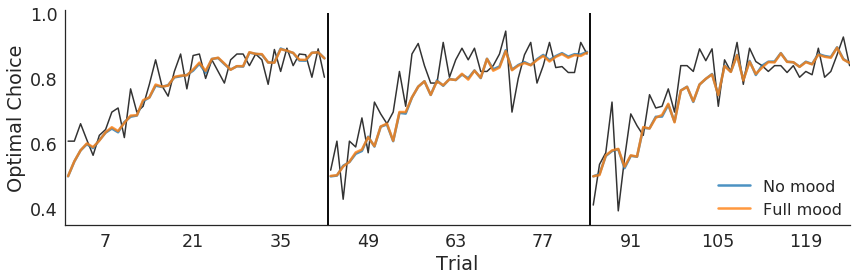

In [7]:
## Define parameters.
models = ['moodRL_original_no_mood', 'moodRL_original_full_mood']
colors = sns.color_palette(n_colors=len(models))
labels = ['No mood', 'Full mood']

## Plot models.
fig, ax = plt.subplots(1,1,figsize=(12,4))
for model, observed, color, label in zip(models, [True,False], colors, labels):
    plot_behavior(model, observed=observed, color=color, label=label, ax=ax)
ax.legend(loc=4, borderpad=0, fontsize=16)

sns.despine()
plt.tight_layout()

The plot above shows very similar performance for the no pool and partially-pooled models. Formally, we compare the models below:

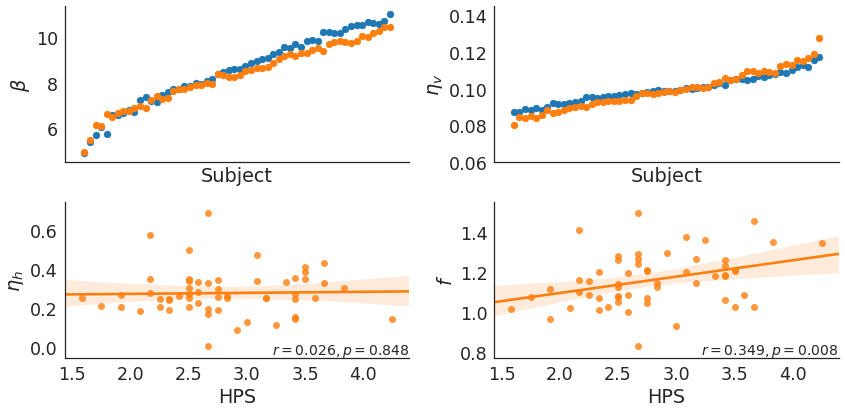

In [8]:
from scripts.utilities import load_fit
from scipy.stats import pearsonr

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

models = ['moodRL_original_no_mood', 'moodRL_original_full_mood']
colors = sns.color_palette(n_colors=len(models))
labels = ['No mood', 'Full mood']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,2,figsize=(12,6))
sns.set_context('notebook', font_scale=1.25)

## Load StanFits.
fits = [load_fit(model) for model in models]

## Plot beta/eta_v
for ax, param, ylabel in zip(axes[0], ['beta', 'eta_v'], [r'$\beta$', r'$\eta_v$']):
    
    param = np.array([np.median(fit[param], axis=0) for fit in fits])
    ix = np.argsort(param.mean(axis=0))
    
    for arr, label, color in zip(param, labels, colors):
        
        ax.scatter(np.arange(ix.size), arr[ix], color=color, label=label)
        
    ax.set(xticks=[], xlabel='Subject', ylabel=ylabel)

## Plot eta_h/f.
for ax, param, ylabel in zip(axes[1], ['eta_h', 'f'], [r'$\eta_h$', r'$f$']):
    
    y = np.median(fits[1][param], axis=0)
    sns.regplot(metadata.IPIP_hps, y, color=colors[1], ax=ax)
    ax.set(xlabel='HPS', ylabel=ylabel)
    ax.annotate(r'$r = %0.3f, p = %0.3f$' %pearsonr(metadata.IPIP_hps, y), xy=(0,0), 
                xytext=(1,0.025), xycoords='axes fraction', ha='right', fontsize=14)
    
sns.despine()
plt.tight_layout()

In [9]:
## Compute model comparison.
model_comparison('moodRL_original_no_mood', 'moodRL_original_full_mood', on='y', verbose=True);

Model comparison
----------------
WAIC[1] = 6224
WAIC[2] = 6216
Diff	= 7.41 (5.22)


### Mood predictions

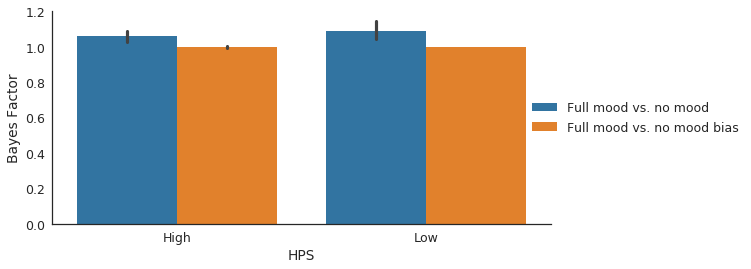

In [10]:
from scripts.utilities import zscore

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate mood.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load fit.
fit = load_fit('moodRL_original_full_mood')
x, y, R = fit['X'] - 1, fit['Y'] - 1, fit['R']
n_samp, n_subj, n_block, n_trial = fit['Y_pred'].shape

## Preallocate space.
h_pred = np.zeros((3, n_samp, n_subj, n_block, n_trial))

for i in np.arange(n_samp):
    
    for j in np.arange(n_subj):
        
        ## Extract parameters.
        eta_v = fit['eta_v'][i,j]
        eta_h = fit['eta_h'][i,j]
        f = fit['f'][i,j]
        
        ## Preallocate space.
        Q1, Q2 = np.zeros((2,9))
        d1, h1, m1 = np.zeros(3)
        d2, h2, m2 = np.zeros(3)
        
        for k in np.arange(n_block):
            
            if k < 2:
                
                ## Update values.
                h1, h2 = h12[j,k].copy(), h12[j,k].copy()
                m1, m2 = np.tanh(h1), np.tanh(h2)
                
                ## Store values.
                h_pred[1,i,j,k,0] = h1
                h_pred[2,i,j,k,0] = h2
            
            for m in np.arange(n_trial-1):
                
                ## Compute RPE.
                d1 = R[j,k,m] - Q1[x[j,k,m,y[j,k,m]]]
                d2 = (f ** m2 * R[j,k,m]) - Q2[x[j,k,m,y[j,k,m]]]
                
                ## Update expectations.
                Q1[x[j,k,m,y[j,k,m]]] += eta_v * d1
                Q2[x[j,k,m,y[j,k,m]]] += eta_v * d2
                
                ## Update history of rewards.
                h1 += eta_h * (d1 - h1)
                h2 += eta_h * (d2 - h2)
                
                ## Store values.
                h_pred[1,i,j,k,m+1] = h1
                h_pred[2,i,j,k,m+1] = h2
                
## Extract observed mood.
M_obs = fit['M']
n_subj, n_block, n_trial = M_obs.shape
M_obs = M_obs.reshape(n_subj, n_block * n_trial)

## Compute predicted mood.
M_pred = np.tanh(h_pred[...,[7,21,35]])
M_pred = M_pred.reshape(3, n_samp, n_subj, n_block * n_trial)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute Bayes Factors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
lppd = np.zeros((3,n_subj))

for k in np.arange(n_subj):
    
    ## Prepare observed mood data.
    x = zscore(M_obs[k].copy())
    if np.all(np.isnan(x)): x = np.zeros_like(x)
        
    for i in np.arange(3):
        
        for j in np.arange(n_samp):
            
            ## Prepare predicted mood data.
            mu = zscore(M_pred[i,j,k].copy())
            if np.all(np.isnan(mu)): mu = np.zeros_like(x)
                
            ## Compute and log-likelihood.
            likelihood = norm.pdf(x, loc=mu, scale=1)
            lppd[i,k] += np.log( np.mean(likelihood) )

## Convert to DataFrame.
df = DataFrame(np.vstack([lppd[2] / lppd[0], lppd[2] / lppd[1]]).T, 
               columns=('Full mood vs. no mood', 'Full mood vs. no mood bias'))
df['HPS'] = np.where(metadata.IPIP_hps > metadata.IPIP_hps.median(), 'High', 'Low')
df = df.melt(id_vars='HPS', var_name='Models', value_name='Bayes Factor')
            
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot.
sns.barplot('HPS', 'Bayes Factor', 'Models', data=df, ax=ax)
ax.legend(loc=7, bbox_to_anchor=(1.4,0.5))

sns.despine()
plt.tight_layout()

## Section 4: Parameter Recovery
### Simulate data

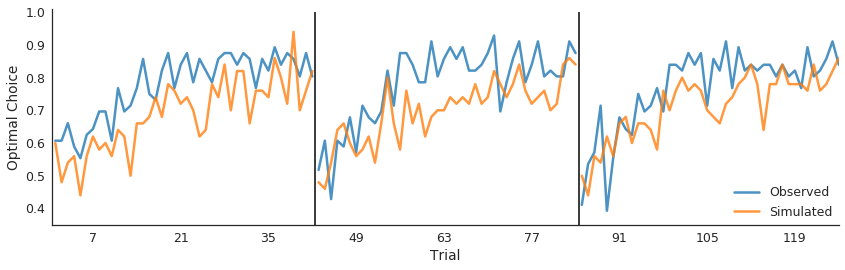

In [11]:
from scripts.simulations import MoodyAgent, slot_machine_game

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
Ns = 50    # subjects
B = 3      # blocks
T = 42     # trials

mu = np.array([9.0, 0.1])
cov = np.array([[1.00,1e-4],
                [1e-4,1e-4]])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(0)

## Simulate agent parameters.
beta, eta_v = np.random.multivariate_normal(mu, cov, Ns).T
eta_h = np.random.normal(0.2,0.05,Ns)
f = np.exp( np.random.normal(0,0.05,Ns) / 2 )

## Preallocate space.
Xs = np.zeros([Ns,B,T,2], dtype=int)
Ys = np.zeros([Ns,B,T], dtype=int)
Rs = np.zeros([Ns,B,T], dtype=int)

for i in np.arange(Ns):
    
    ## Initialize agent.
    agent = MoodyAgent(beta=beta[i], eta_v=eta_v[i], eta_h=eta_h[i], f=f[i])
    
    for j in np.arange(B):
        
        ## Simulate block of trials.
        x, r = slot_machine_game(n_trials=T, probabilities=(0.2,0.4,0.6), reward=1)
        
        ## Simulate behavior.
        y, _ = agent.simulate(x,r)
        
        ## Store.
        Xs[i,j] = x.copy() + j * B
        Ys[i,j] = y.copy()
        Rs[i,j] = [r[a,b] for a,b in enumerate(y)]

## Make arrays 1-indexed.
Xs += 1
Ys += 1
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = sns.color_palette(n_colors=2)
labels = ['Observed','Simulated']

for x, y, label, color in zip([X,Xs],[Y,Ys],labels,colors):
    
    ## Compute optimal choice.
    optimal_choice = np.argmax(x, axis=-1)
    y = np.equal(y-1, optimal_choice).astype(int)
    y = np.mean(y, axis=0)

    for j in np.arange(B):
    
        ## Define trial numbers.
        trials = np.arange(T) + j * T
        trials += 1

        ## Plot.
        ax.plot( trials, y[j], lw=2.5, label=label, color=color, alpha=0.8 )
        label = None
        
## Add info.
ax.vlines([42.5, 84.5], 0, 1, lw=1.5, color='k', zorder=10)
ax.set(xlim=(0.5,126), xticks=np.arange(7,126,14), xlabel='Trial',
       ylim=(0.35, 1.01), ylabel='Optimal Choice')
ax.legend(loc=4, borderpad=0)

sns.despine()
plt.tight_layout()

### Model fitting

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Organize data dictionary.

dd = dict(N=Ns, B=B, T=T, X=Xs, Y=Ys, R=Rs, h12=np.zeros([Ns,2]))

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, chains=chains, 
                      control=dict(adapt_delta = 0.9), n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s_recovery' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as fn: cPickle.dump(extract, fn)
        
    print('Done.')

### Posterior predictive checks

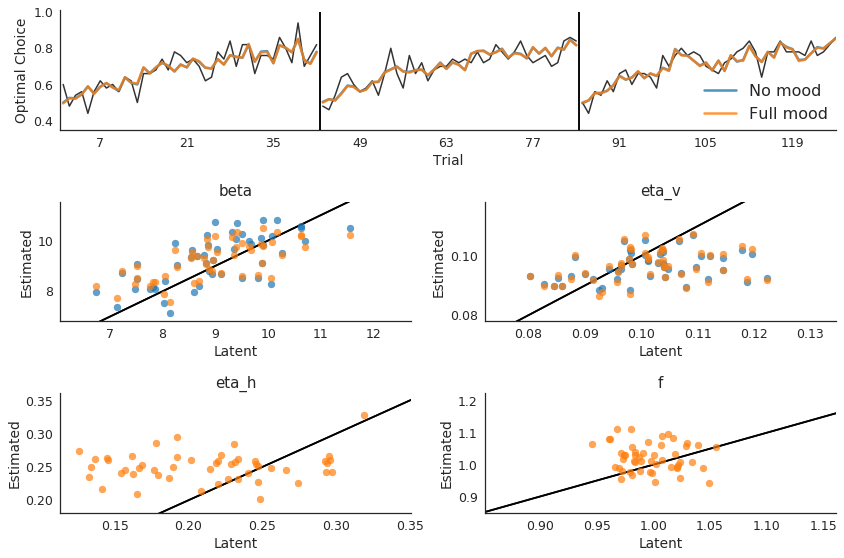

In [13]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

models = ['moodRL_original_no_mood_recovery', 'moodRL_original_full_mood_recovery']
colors = sns.color_palette(n_colors=len(models))
labels = ['No mood', 'Full mood']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,8))
sns.set_context('notebook', font_scale=1.25)

top = plt.subplot2grid((3,2),(0,0),colspan=2)
axes = [plt.subplot2grid((3,2),(i//2+1,i%2)) for i in np.arange(4)]

for model, observed, color, label in zip(models, [True,False], colors, labels):
    
    ## Plot behavior.
    plot_behavior(model, observed=observed, color=color, label=label, ax=top)
    
    ## Load model fit.
    fn = 'stan_fits/%s/StanFit.pickle' %model
    with open(fn, 'rb') as fn: fit = cPickle.load(fn)
    
    for ax, x, param in zip(axes, [beta,eta_v,eta_h,f], ['beta','eta_v','eta_h','f']):
        
        ## Plot (if parameter in StanFit).
        if param in fit.keys():
            y = np.median(fit[param], axis=0)
            ax.scatter(x, y, color=color, alpha=0.7)
        
        ## Add info.
        ax.plot((x.min()*0.9, x.max()*1.1), (x.min()*0.9, x.max()*1.1), color='k', zorder=0)
        ax.set(xlim=(x.min()*0.9, x.max()*1.1), xlabel=r'Latent', 
               ylim=(y.min()*0.9, y.max()*1.1), ylabel='Estimated', title=param)
    
## Add legend
top.legend(loc=4, borderpad=0, fontsize=16)

sns.despine()
plt.tight_layout()

In [14]:
## Compute model comparison.
model_comparison(*models, on='y', verbose=True);

Model comparison
----------------
WAIC[1] = 5327
WAIC[2] = 5331
Diff	= -3.73 (1.35)
